#### Important Equations

In [1]:
# (Kalman Gain) = kg
# (Error Estimate) = e_est
# (Error Measurement) = e_mea
# (Current Estimate) = est_t
# (Previous Estimate) = est_t-1
# (Measurement) = mea
# [Kalman Gain]
# kg = (e_est)/((e_est)+(e_mea))
# [Current Estimate]
# est_t = ((est_t-1) + kg(mea - est_t-1))
# e_est{t} = ((e_mea)(e_est{t-1})/((e_mea)+(e_est{t-1}))

#### Step 1: Data Wrangling

In [227]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Load data
sat_a = pd.read_csv("Sentinel_3A.csv")
sat_a.head()

,Date (YYYYMMDD),Lake_name,Latitude,Longitude,Relaive_orbit,Lake water level (m)
0,20160403,Athabasca,59.244637,-108.047469,303,208.303892
1,20160403,Athabasca,59.247528,-108.049405,303,208.131251
2,20160403,Athabasca,59.250420,-108.051342,303,208.550610
3,20160403,Athabasca,59.253311,-108.053278,303,208.300569
4,20160403,Athabasca,59.256202,-108.055216,303,208.333929


In [8]:
sat_b = pd.read_csv("Sentinel_3B.csv")
sat_b.head()

,Date (YYYYMMDD),Lake_name,Latitude,Longitude,Relaive_orbit,Lake water level (m)
0,20180512,Athabasca,59.365696,-107.680063,98,209.3384
1,20180512,Athabasca,59.362814,-107.682010,98,209.5665
2,20180512,Athabasca,59.359931,-107.683956,98,209.6700
3,20180512,Athabasca,59.357049,-107.685902,98,209.5169
4,20180512,Athabasca,59.354166,-107.687848,98,209.4275


In [11]:
# Create one Dataframe
frames = [sat_a, sat_b]
data = pd.concat(frames)
data.head()

,Date (YYYYMMDD),Lake_name,Latitude,Longitude,Relaive_orbit,Lake water level (m)
0,20160403,Athabasca,59.244637,-108.047469,303,208.303892
1,20160403,Athabasca,59.247528,-108.049405,303,208.131251
2,20160403,Athabasca,59.250420,-108.051342,303,208.550610
3,20160403,Athabasca,59.253311,-108.053278,303,208.300569
4,20160403,Athabasca,59.256202,-108.055216,303,208.333929


In [12]:
# Rename inconvenient columns
sat = data.rename(columns={'Date (YYYYMMDD)': 'date', 'Lake_name': 'lake', 'Relaive_orbit': 'orbit', 'Lake water level (m)': 'water_level'})
sat.head()

,date,lake,Latitude,Longitude,orbit,water_level
0,20160403,Athabasca,59.244637,-108.047469,303,208.303892
1,20160403,Athabasca,59.247528,-108.049405,303,208.131251
2,20160403,Athabasca,59.250420,-108.051342,303,208.550610
3,20160403,Athabasca,59.253311,-108.053278,303,208.300569
4,20160403,Athabasca,59.256202,-108.055216,303,208.333929


In [61]:
# Isolate Three Lakes
# Athabasca
dfath = sat[sat['lake'] == 'Athabasca']
dfath.head()

,date,lake,Latitude,Longitude,orbit,water_level
0,20160403,Athabasca,59.244637,-108.047469,303,208.303892
1,20160403,Athabasca,59.247528,-108.049405,303,208.131251
2,20160403,Athabasca,59.250420,-108.051342,303,208.550610
3,20160403,Athabasca,59.253311,-108.053278,303,208.300569
4,20160403,Athabasca,59.256202,-108.055216,303,208.333929


In [62]:
# Great Slave
dfgr = sat[sat['lake'] == 'Great Slave']
dfgr.head()

,date,lake,Latitude,Longitude,orbit,water_level
54265,20160401,Great Slave,62.627736,-115.414797,284,157.051844
54266,20160401,Great Slave,62.624878,-115.417140,284,156.756702
54267,20160401,Great Slave,62.619163,-115.421827,284,156.577419
54268,20160401,Great Slave,62.613447,-115.426511,284,156.586135
54269,20160401,Great Slave,62.607731,-115.431194,284,156.549751


In [59]:
# Lesser Slave
dfle = sat[sat['lake'] == 'Lesser Slave']
dfle.head()

,date,lake,Latitude,Longitude,orbit,water_level
215027,20160413,Lesser Slave,55.414691,-116.000375,61,575.7888
215028,20160413,Lesser Slave,55.417525,-116.001941,61,575.9596
215029,20160413,Lesser Slave,55.420360,-116.003507,61,575.7748
215030,20160413,Lesser Slave,55.423196,-116.005073,61,575.7656
215031,20160413,Lesser Slave,55.426030,-116.006639,61,575.9087


#### Step 2: EDA

In [57]:
# Lesser Slave Lake

In [60]:
less = dfle.sort_values('date')
less.tail()

,date,lake,Latitude,Longitude,orbit,water_level
221009,20210913,Lesser Slave,55.421090,-115.548599,184,576.527827
221010,20210913,Lesser Slave,55.418255,-115.550167,184,576.401274
221011,20210913,Lesser Slave,55.415420,-115.551734,184,576.417921
220999,20210913,Lesser Slave,55.449438,-115.532907,184,576.361660
221042,20210913,Lesser Slave,55.327534,-115.600239,184,575.941938


In [32]:
less.date.nunique()

252

In [43]:
lesser = less.date.unique()
less_mean = []

In [44]:
for l in lesser: 
    less_mean.append((less[less['date'] == l].water_level).mean())

In [55]:
# Three Standard Deviations Taken
elements = np.array(less_mean)
mean = np.mean(elements, axis=0)
sd = np.std(elements, axis=0)
less_list = [x for x in less_mean if (x > mean - 3 * sd)]
less_list = [x for x in less_list if (x < mean + 3 * sd)]

In [56]:
len(less_list)

248

In [58]:
# Greater Slave Lake

In [63]:
great = dfgr.sort_values('date')
great.tail()

,date,lake,Latitude,Longitude,orbit,water_level
212654,20210929,Great Slave,61.446536,-114.301019,18,156.729195
212653,20210929,Great Slave,61.443740,-114.298889,18,156.713327
212652,20210929,Great Slave,61.440944,-114.296760,18,156.648259
212666,20210929,Great Slave,61.480091,-114.326599,18,156.734574
213012,20210929,Great Slave,62.523925,-115.149802,18,156.633007


In [64]:
great.date.nunique()

1328

In [75]:
greater = great.date.unique()
great_mean = []

In [76]:
for g in greater: 
    great_mean.append((great[great['date'] == g].water_level).mean())

In [77]:
# Three Standard Deviations Taken
elements = np.array(great_mean)
mean = np.mean(elements, axis=0)
sd = np.std(elements, axis=0)
great_list = [x for x in great_mean if (x > mean - 3 * sd)]
great_list = [x for x in great_list if (x < mean + 3 * sd)]

In [80]:
len(great_list)

1308

In [81]:
# Athabasca

In [82]:
ath = dfath.sort_values('date')
ath.tail()

,date,lake,Latitude,Longitude,orbit,water_level
45246,20210929,Athabasca,59.403541,-109.380034,27,209.494051
45247,20210929,Athabasca,59.400729,-109.381936,27,209.329970
45248,20210929,Athabasca,59.397916,-109.383837,27,209.403088
45274,20210929,Athabasca,59.324784,-109.433165,27,209.466858
45369,20210929,Athabasca,59.057448,-109.611804,27,210.599848


In [83]:
ath.date.nunique()

648

In [84]:
atha = ath.date.unique()
ath_mean = []

In [85]:
for a in atha: 
    ath_mean.append((ath[ath['date'] == a].water_level).mean())

In [87]:
# Three Standard Deviations Taken
elements = np.array(ath_mean)
mean = np.mean(elements, axis=0)
sd = np.std(elements, axis=0)
ath_list = [x for x in ath_mean if (x > mean - 3 * sd)]
ath_list = [x for x in ath_list if (x < mean + 3 * sd)]

In [88]:
len(ath_list)

638

#### Step 3: Calculating Kalman Gains

In [92]:
# Error in the measurement has been stated by the ESA to be +/- 10 to 15(cm)
# Initial estimated error in the measurement is +/- 12.5(cm) --> (Taking the median)
# Initial estimated error in the estimate is 2.5cm --> (Difference from the median)

##### Lesser Slave Lake

In [299]:
total = 0
nums = 0
for i in less_list:
    total += i
    nums += 1

In [300]:
mea = less_list[0]
est_p = total/nums
e_est = 2.5
e_mea = 12.5

In [301]:
old = e_est
new = e_est
estimate = est_p

In [302]:
# Initial Kalman Gain
kg = (new/(new+e_mea))/(100) # ---> Convert cm to m ---> ~0.00167
# (Current Estimate)
est_t = ((less_list[0]) + kg*(less_list[0] + estimate))
# Current Error in the Estimate
new = (1 - kg)*(old) 

In [303]:
# List of Estimates / List of Kalman Gains / List of Errors in the Estimate
estimate_list_l = []
kalman_gains_l = []
errors_l = []

In [304]:
for i in range(len(less_list)):
    # Initial Kalman Gain
    kg = (old/(old+e_mea))/(100)
    # (Current Estimate)
    est_t = ((less_list[i]) + kg*(less_list[i] + estimate))
    # Current Error in the Estimate
    new = (1 - kg)*(old)
    # Update previous error in estimate
    old = new
    estimate_list_l.append(est_t)
    kalman_gains_l.append(kg)
    errors_l.append(new)
print("The Kalman Gain for Lesser Slave Lake is: ", kg)
    
    

The Kalman Gain for Lesser Slave Lake is:  0.001231552061782597


##### Lake Athabasca

In [293]:
total = 0
nums = 0
for i in ath_list:
    total += i
    nums += 1

In [294]:
mea = ath_list[0]
est_p = total/nums
e_est = 2.5
e_mea = 12.5

In [295]:
old = e_est
new = e_est
estimate = est_p

In [296]:
# Initial Kalman Gain
kg = (new/(new+e_mea))/(100) # ---> Convert cm to m ---> ~0.00167
# (Current Estimate)
est_t = ((ath_list[0]) + kg*(ath_list[0] + estimate))
# Current Error in the Estimate
new = (1 - kg)*(old) 

In [297]:
# List of Estimates / List of Kalman Gains / List of Errors in the Estimate
estimate_list_a = []
kalman_gains_a = []
errors_a = []

In [298]:
for i in range(len(ath_list)):
    # Initial Kalman Gain
    kg = (old/(old+e_mea))/(100)
    # (Current Estimate)
    est_t = ((ath_list[i]) + kg*(ath_list[i] + estimate))
    # Current Error in the Estimate
    new = (1 - kg)*(old)
    # Update previous error in estimate
    old = new
    estimate_list_a.append(est_t)
    kalman_gains_a.append(kg)
    errors_a.append(new)
print("The Kalman Gain for Lake Athabasca is: ", kg)
    

The Kalman Gain for Lake Athabasca is:  0.0008603296001109918


##### Great Slave Lake

In [286]:
total = 0
nums = 0
for i in great_list:
    total += i
    nums += 1

In [287]:
mea = great_list[0]
est_p = total/nums
e_est = 2.5
e_mea = 12.5

In [288]:
old = e_est
new = e_est
estimate = est_p

In [289]:
# Initial Kalman Gain
kg = (new/(new+e_mea))/(100) # ---> Convert cm to m ---> ~0.00167
# (Current Estimate)
est_t = ((great_list[0]) + kg*(great_list[0] + estimate))
# Current Error in the Estimate
new = (1 - kg)*(old) 

In [290]:
# List of Estimates / List of Kalman Gains / List of Errors in the Estimate
estimate_list_g = []
kalman_gains_g = []
errors_g = []

In [291]:
for i in range(len(great_list)):
    # Initial Kalman Gain
    kg = (old/(old+e_mea))/(100)
    # (Current Estimate)
    est_t = ((great_list[i]) + kg*(great_list[i] + estimate))
    # Current Error in the Estimate
    new = (1 - kg)*(old)
    # Update previous error in estimate
    old = new
    estimate_list_g.append(est_t)
    kalman_gains_g.append(kg)
    errors_g.append(new)
print("The Kalman Gain for Great Slave Lake is: ", kg)
    

The Kalman Gain for Great Slave Lake is:  0.0005597318911788747


#### Part 4: Visualising the Results

In [271]:
# Great Slave Lake

In [272]:
# Water Levels 2016 - 2021

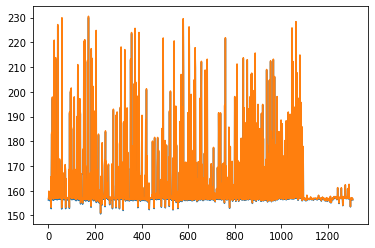

In [292]:
y = great_list
y2 = estimate_list_g
x = range(len(great_list))

plt.plot(x,y, y2)

In [273]:
# Lesser Slave Lake

In [274]:
# Water Levels 2016 - 2021

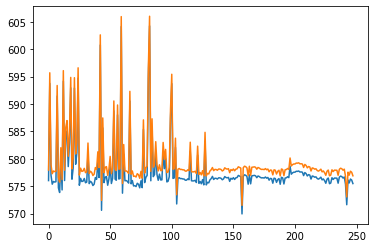

In [305]:
y = less_list
y2 = estimate_list_l
x = range(len(less_list))

plt.plot(x,y, y2)

In [276]:
# Lesser Slave Lake

In [275]:
# Water Levels 2016 - 2021

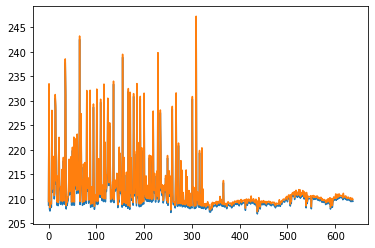

In [306]:
y = ath_list
y2 = estimate_list_a
x = range(len(ath_list))

plt.plot(x,y, y2)

#### Step Extra...

In [281]:
# Graph the lists of Kalman Gains against Estimated water levels against Estimated Errors

In [308]:
# Make graphs large and well labeled and lemony fresh. 